In [1]:
import torch
torch.manual_seed(0)

import random
random.seed(0)

import numpy as np
np.random.seed(0)

In [2]:
def load(fn):
    with open(fn, 'r') as file_in:
        return file_in.read().split('\n')

In [3]:
def repl_t(text):
    text = text.replace('(t1)', '(x1)')
    text = text.replace('(t2)', '(x2)')
    text = text.replace('(t1,t2)', '(x1,x2)')
    return text

In [4]:
id_pairs = [[int(x) for x in l.split('\t')] for l in load('id_pairs.txt') if l != '']
sid2uids = {}

for s, u in id_pairs:
    if s not in sid2uids:
        sid2uids[s] = []
    sid2uids[s].append(u)

In [5]:
situations = [[int(l.split('\t')[0]), l.split('\t')[1]] for l in load('situations.txt') if l != '']

In [6]:
utterances = [[int(l.split('\t')[0]), l.split('\t')[1]] for l in load('utterances.txt') if l != '']

In [7]:
sit2id = {s[1]: s[0] for s in situations}

In [8]:
train_sit = [l.split('\t')[0] for l in load('training_set.txt')]
valid_sit = [l.split('\t')[0] for l in load('test_set.txt')]

In [9]:
train_sit_id = [sit2id[repl_t(s)] for s in train_sit if s != '']
valid_sit_id = [sit2id[repl_t(s)] for s in valid_sit if s != '']

In [10]:
import torch.nn.functional as F
import torch

class Vocab():
    def __init__(self):
        self.vocab = {}
        self.invert = {}
        self.len = 0
    
    def update(self, text, verbose=False):
        for char in text:
            if char not in self.vocab:
                self.vocab[char] = self.len
                self.invert[self.len] = char
                self.len += 1
                if verbose:
                    print('vocab size:', self.len, char)
    
    def tokenize(self, text):
        return torch.tensor([self.vocab[c] for c in text])
    
    def tokenize_oh(self, text):
        return F.one_hot(self.tokenize(text), num_classes=len(self))
    
    def decode(self, ids):
        return [self.invert[x.item()] for x in ids]
    
    def __len__(self):
        return self.len

In [11]:
import re

class PhraseVocab(Vocab):
    def __init__(self):
        self.vocab = {}
        self.invert = {}
        self.len = 0
        self.split_chars = [' ', ')', '(', ',']
        
    def split(self, text):
        for s in self.split_chars:
            text = text.replace(s, self.split_chars[0])
        text_tokens = text.split(self.split_chars[0])
        return text_tokens
    
    def update(self, text, verbose=True):
        text_tokens = self.split(text)
        for token in text_tokens:
            if token not in self.vocab:
                self.vocab[token] = self.len
                self.invert[self.len] = token
                self.len += 1
                if verbose:
                    print('vocab size:', self.len, token)
    
    def tokenize(self, text):
        return torch.tensor([self.vocab[c] for c in self.split(text)])
    
    def tokenize_oh(self, text):
        return F.one_hot(self.tokenize(text), num_classes=len(self))
    
    def decode(self, ids):
        result = []
        
        for x in ids:
            if torch.is_tensor(x):
                x = x.item()
            result.append(self.invert[x])

        return result

In [12]:
type_dict = {
    'shapes': ['ellipse', 'star', 'circle', 'square', 'hexagon', 'triangle']
}

def count_types(text, type_name):
    count = 0
    for tn in type_dict[type_name]:
        count += text.count(tn)
    return count

In [13]:
v1 = PhraseVocab()
v2 = PhraseVocab()
for s in [s[1] for s in situations]:
    v1.update(s)

for u in [u[1] for u in utterances]:
    v2.update(u)

vocab size: 1 me1
vocab size: 2 x1
vocab size: 3 
vocab size: 4 bl1
vocab size: 5 el1
vocab size: 6 ab2
vocab size: 7 x2
vocab size: 8 sm1
vocab size: 9 ye1
vocab size: 10 re1
vocab size: 11 st1
vocab size: 12 bi1
vocab size: 13 gr1
vocab size: 14 ci1
vocab size: 15 sq1
vocab size: 16 le2
vocab size: 17 pu1
vocab size: 18 he1
vocab size: 19 or1
vocab size: 20 tr1
vocab size: 1 the
vocab size: 2 medium
vocab size: 3 blue
vocab size: 4 ellipse
vocab size: 5 above
vocab size: 6 below
vocab size: 7 red
vocab size: 8 star
vocab size: 9 yellow
vocab size: 10 small
vocab size: 11 big
vocab size: 12 circle
vocab size: 13 green
vocab size: 14 to
vocab size: 15 right
vocab size: 16 of
vocab size: 17 square
vocab size: 18 left
vocab size: 19 hexagon
vocab size: 20 purple
vocab size: 21 orange
vocab size: 22 triangle


In [14]:
v2.update('!')
v2.update('^')

vocab size: 23 !
vocab size: 24 ^


In [15]:
def id_select(ids, targets):
    result = []
    for target_id in ids:
        result.append(targets[target_id - 1][1])
    return result

In [16]:
import torch.nn as nn

class RNNEnc(nn.Module):
    def __init__(self, input_size=300, hidden_size=300):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn_enc = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=1)
        
        #self.lin_input = nn.Linear(30, 128)
        self.embed = nn.Embedding(len(v1), self.input_size)
    
        self.relu = nn.ReLU()
    
        self.enc_lin = nn.Linear(self.hidden_size, self.hidden_size)
    
    def forward(self, x): # seq_length
        x = self.embed(x).unsqueeze(1) # seq_length x 1 x 128
        x = self.relu(x)
        
        h0 = torch.zeros((1, 1, self.hidden_size))
        
        enc_out, enc_hidden = self.rnn_enc(x, h0)
        # enc_out: seq_length x 1 x 128
        # enc_hidden: 1 x 1 x 128
        
        #enc_out = self.enc_lin(enc_out.squeeze(1))
        #enc_out = self.relu(enc_out) # seq_length x 300
        
        enc_out = enc_out.squeeze(1)
        
        return enc_out, enc_hidden

In [17]:
class RNNDec(nn.Module):
    def __init__(self, embed, input_size=(300), hidden_size=300, max_length=22):
        super().__init__()
        
        self.max_length = max_length
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn_dec = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=1)
        
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.lin_output = nn.Linear(self.hidden_size, len(v2))
        #self.lin_hidden = nn.Linear(256, 128)
        self.embed = nn.Embedding(len(v2), 300)
        
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, x, enc_hidden, h, enc_out):
        # x: 1
        # h: 1 x 1 x 300
        x = self.embed(x).reshape(1, -1) # 1 x 300
        x = self.dropout(x)
        
        #enc_hidden = self.lin_hidden(enc_hidden)
        #enc_hidden = self.relu(enc_hidden)
        
        #print(torch.cat((x[0], enc_hidden[0]), dim=1).shape)
        
        attn_weights = F.softmax(self.attn(torch.cat((x, enc_hidden[0]), dim=1)), dim=1) # 1 x max_length
        
        #seq_length = enc_out.shape[0]
        #attn_weights = attn_weights[:, :seq_length] # 1 x seq_length
        
        attn_applied = torch.mm(attn_weights, enc_out) # (1 x seq_length) x (seq_length x 300) = (1 x 300)
        
        rnn_in = torch.cat((x, attn_applied), dim=1)
        rnn_in = self.attn_combine(rnn_in).unsqueeze(0)
        rnn_in = F.relu(rnn_in)
        
        dec_out, dec_hidden = self.rnn_dec(rnn_in, h)
        # dec_out: 1 x 1 x 300
        # dec_hidden: 1 x 1 x 300
        
        logits = self.lin_output(dec_out[0]) # 1 x 30
        
        #probs = self.softmax(logits)
        
        return logits, dec_hidden

In [18]:
from torch import optim

eos_id = v2.tokenize('!')[0]
start_id = v2.tokenize('^')[0]

enc = RNNEnc()
dec = RNNDec(enc.embed)

opt_enc = optim.Adam(enc.parameters(), lr=1e-4)
opt_dec = optim.Adam(dec.parameters(), lr=1e-4)

ce_loss = nn.CrossEntropyLoss()

In [19]:
force_p = [0.0]
def force_p_schedule(epoch_idx):
    if epoch_idx >= len(force_p):
        return force_p[-1]
    return force_p[epoch_idx]

In [20]:
%load_ext autoreload
%autoreload 2

In [21]:
from plotter import Plotter
plot = Plotter()

In [22]:
validspl_sit_id = valid_sit_id
trainspl_sit_id = train_sit_id

In [23]:
from jellyfish import jaro_similarity

In [24]:
def model_forward(input_sit_str, epoch_idx, grad=True, max_length=20):
    input_sit = v1.tokenize(input_sit_str)

    if grad:
        enc_out, enc_hidden = enc(input_sit)
    else:
        with torch.no_grad():
            enc_out, enc_hidden = enc(input_sit)

    pred_ids = []
    pred_logits = []
    
    prev = start_id
    h = enc_hidden
    for i in range(max_length):
        if grad:
            logits, h = dec(prev, enc_hidden, h, enc_out)
        else:
            with torch.no_grad():
                logits, h = dec(prev, enc_hidden, h, enc_out)

        pred = torch.argmax(logits, dim=1)[0]
        prev = pred
        
        pred_ids.append(pred)
        pred_logits.append(logits)
        
        #print(logits[0], tu_target[i])

        #loss += ce_loss(logits, tu_target[i].unsqueeze(0))

        if pred == eos_id:
            break
    
    return pred_ids, pred_logits

In [25]:
class RunningAvg:
    def __init__(self, buffer_size, default=None):
        self.buffer = [default] * buffer_size
        self.idx = 0
        self.buffer_size = buffer_size
    
    def __call__(self, x):
        self.buffer[self.idx % self.buffer_size] = x
        self.idx += 1
        return self.none_avg()
    
    def none_avg(self):
        return sum([b for b in self.buffer if b != None])/self.buffer_size

In [26]:
train_edit_run = RunningAvg(10)
train_loss_run = RunningAvg(10)

In [27]:
import feedback

In [28]:
def closest_loss(cleaned_pred, pred_logits, target_utters):
    # get label
    #utter_dists = [(jaro_similarity(t, cleaned_pred), t) for t in target_utters]
    #utter_closest = max(utter_dists, key=lambda x:x[0])[1] + ' !'

    utter_feedback = feedback.get_feedback_sentence(target_utters, cleaned_pred) + ' !'
    
    #print(utter_feedback)
    
    #print(utter_closest, '|', ' '.join(v.decode(pred_ids)))

    tu_target = v2.tokenize(utter_feedback)

    # get loss
    loss = 0.0
    for tkn_idx in range(min(len(pred_logits), len(tu_target))):
        loss += ce_loss(pred_logits[tkn_idx], tu_target[tkn_idx].unsqueeze(0))
    
    return loss, utter_feedback

In [29]:
update_every = False
def is_correct(pred, targets):
    if pred in targets and not update_every:
        return 0.0
    return 1.0

  0%|          | 0/18000 [00:00<?, ?it/s]

force_p: 0.0


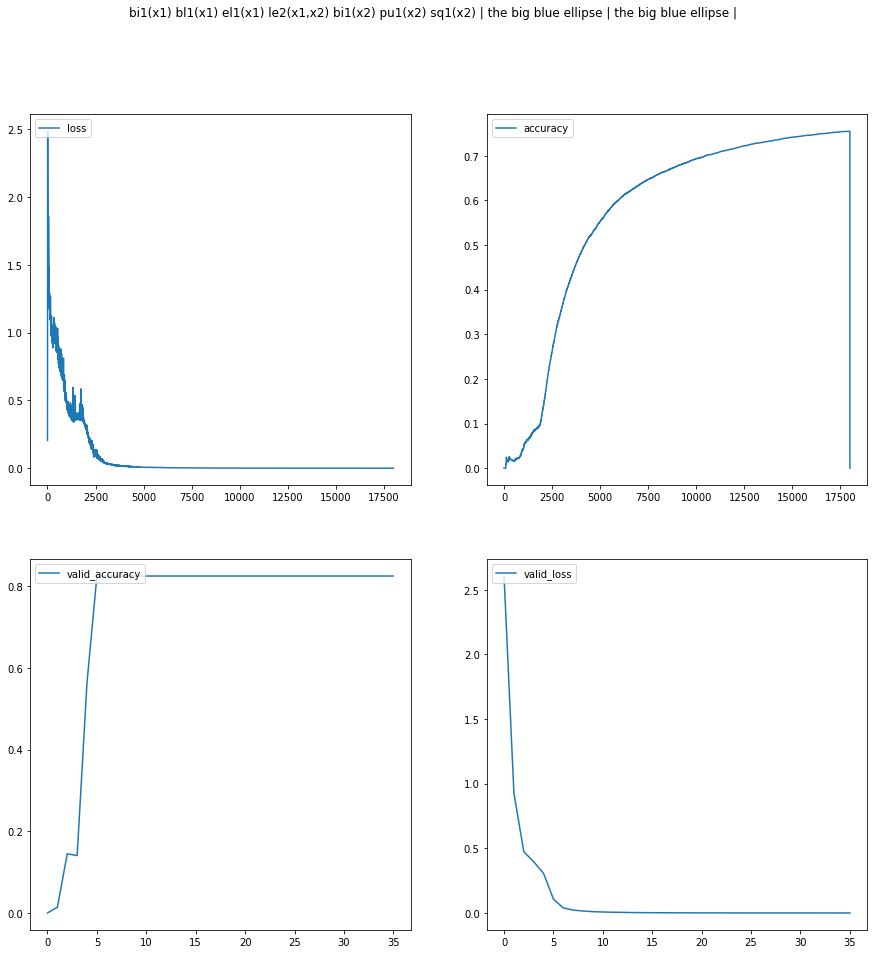

  0%|          | 0/5000 [00:00<?, ?it/s]

the big blue circle bi1(x1) bl1(x1) ci1(x1) le2(x1,x2) sm1(x2) re1(x2) ci1(x2)
['the big blue circle to the left of the red circle', 'the small red circle to the right of the big circle', 'the circle to the left of the circle', 'the circle to the right of the big circle', 'the blue circle to the left of the red circle', 'the red circle to the right of the big blue circle', 'the small circle to the right of the circle', 'the blue circle to the left of the circle', 'the circle to the right of the big blue circle', 'the small circle to the right of the blue circle', 'the red circle to the right of the blue circle', 'the circle to the left of the small red circle', 'the circle to the left of the small circle', 'the small red circle to the right of the circle', 'the big blue circle to the left of the small red circle', 'the big circle to the left of the circle', 'the small circle to the right of the big blue circle', 'the big circle to the left of the red circle', 'the red circle to the rig

the big red hexagon bi1(x1) re1(x1) he1(x1) ab2(x1,x2) me1(x2) re1(x2) he1(x2)
['the medium hexagon below the hexagon', 'the red hexagon below the big hexagon', 'the red hexagon below the red hexagon', 'the medium red hexagon below the hexagon', 'the big red hexagon above the medium red hexagon', 'the hexagon above the red hexagon', 'the red hexagon above the medium hexagon', 'the big hexagon above the red hexagon', 'the hexagon below the big red hexagon', 'the medium red hexagon below the big red hexagon', 'the hexagon above the medium red hexagon', 'the red hexagon below the hexagon', 'the hexagon above the medium hexagon', 'the hexagon below the hexagon', 'the medium hexagon below the red hexagon', 'the big hexagon above the medium hexagon', 'the red hexagon above the medium red hexagon', 'the red hexagon above the hexagon', 'the medium red hexagon below the red hexagon', 'the big red hexagon above the hexagon', 'the hexagon below the red hexagon', 'the hexagon above the hexagon', '

the big green square bi1(x1) gr1(x1) sq1(x1) le2(x1,x2) me1(x2) re1(x2) sq1(x2)
['the medium square to the right of the square', 'the red square to the right of the green square', 'the square to the left of the square', 'the big green square to the left of the medium square', 'the big green square to the left of the square', 'the red square to the right of the square', 'the medium red square to the right of the green square', 'the red square to the right of the big green square', 'the green square to the left of the medium red square', 'the medium square to the right of the big square', 'the square to the left of the medium square', 'the big green square to the left of the red square', 'the big green square to the left of the medium red square', 'the red square to the right of the big square', 'the big square to the left of the square', 'the green square to the left of the square', 'the medium square to the right of the big green square', 'the square to the right of the square', 'the g

the medium orange square me1(x1) or1(x1) sq1(x1) le2(x1,x2) bi1(x2) bl1(x2) sq1(x2)
['the blue square to the right of the square', 'the square to the left of the square', 'the medium square to the left of the big square', 'the big square to the right of the medium orange square', 'the square to the left of the blue square', 'the big blue square to the right of the orange square', 'the orange square to the left of the blue square', 'the square to the left of the big square', 'the medium square to the left of the blue square', 'the big blue square to the right of the medium square', 'the blue square to the right of the medium square', 'the big blue square to the right of the square', 'the big square to the right of the medium square', 'the orange square to the left of the big square', 'the big square to the right of the orange square', 'the square to the right of the square', 'the blue square to the right of the medium orange square', 'the big blue square to the right of the medium orang

the medium purple triangle me1(x1) pu1(x1) tr1(x1) ab2(x1,x2) bi1(x2) bl1(x2) tr1(x2)
['the blue triangle below the medium purple triangle', 'the medium triangle above the triangle', 'the medium purple triangle above the blue triangle', 'the triangle above the triangle', 'the big blue triangle below the medium triangle', 'the purple triangle above the triangle', 'the big blue triangle below the purple triangle', 'the medium triangle above the big triangle', 'the big triangle below the purple triangle', 'the big triangle below the medium purple triangle', 'the triangle below the triangle', 'the purple triangle above the blue triangle', 'the purple triangle above the big triangle', 'the big triangle below the triangle', 'the blue triangle below the triangle', 'the triangle above the blue triangle', 'the big blue triangle below the medium purple triangle', 'the medium purple triangle above the big blue triangle', 'the blue triangle below the medium triangle', 'the triangle below the mediu

the big green hexagon bi1(x1) gr1(x1) he1(x1) ab2(x1,x2) me1(x2) bl1(x2) he1(x2)
['the medium hexagon below the hexagon', 'the medium hexagon below the green hexagon', 'the green hexagon above the blue hexagon', 'the blue hexagon below the big green hexagon', 'the medium hexagon below the big green hexagon', 'the big green hexagon above the medium blue hexagon', 'the green hexagon above the hexagon', 'the hexagon below the big green hexagon', 'the medium blue hexagon below the big green hexagon', 'the green hexagon above the medium blue hexagon', 'the hexagon above the blue hexagon', 'the medium blue hexagon below the green hexagon', 'the big green hexagon above the hexagon', 'the hexagon above the medium hexagon', 'the hexagon below the green hexagon', 'the hexagon below the hexagon', 'the medium blue hexagon below the big hexagon', 'the hexagon above the medium blue hexagon', 'the blue hexagon below the green hexagon', 'the big hexagon above the medium hexagon', 'the medium blue hexa

the medium red hexagon me1(x1) re1(x1) he1(x1) le2(x1,x2) me1(x2) bl1(x2) he1(x2)
['the hexagon to the right of the medium red hexagon', 'the medium hexagon to the right of the red hexagon', 'the medium blue hexagon to the right of the red hexagon', 'the red hexagon to the left of the blue hexagon', 'the hexagon to the left of the blue hexagon', 'the red hexagon to the left of the hexagon', 'the blue hexagon to the right of the hexagon', 'the medium hexagon to the right of the hexagon', 'the hexagon to the left of the medium blue hexagon', 'the medium blue hexagon to the right of the hexagon', 'the medium red hexagon to the left of the hexagon', 'the hexagon to the right of the medium hexagon', 'the medium blue hexagon to the right of the medium red hexagon', 'the medium hexagon to the right of the medium red hexagon', 'the hexagon to the right of the red hexagon', 'the medium hexagon to the left of the hexagon', 'the red hexagon to the left of the medium hexagon', 'the blue hexagon to

the big green hexagon bi1(x1) gr1(x1) he1(x1) le2(x1,x2) bi1(x2) re1(x2) he1(x2)
['the green hexagon to the left of the big red hexagon', 'the big hexagon to the left of the big red hexagon', 'the big hexagon to the left of the hexagon', 'the hexagon to the right of the big hexagon', 'the big hexagon to the left of the big hexagon', 'the red hexagon to the right of the big green hexagon', 'the big hexagon to the right of the big hexagon', 'the big hexagon to the left of the red hexagon', 'the red hexagon to the right of the green hexagon', 'the big red hexagon to the right of the green hexagon', 'the big green hexagon to the left of the red hexagon', 'the green hexagon to the left of the big hexagon', 'the green hexagon to the left of the hexagon', 'the red hexagon to the right of the hexagon', 'the hexagon to the left of the big hexagon', 'the hexagon to the left of the red hexagon', 'the big red hexagon to the right of the hexagon', 'the red hexagon to the right of the big hexagon', 

the big red circle bi1(x1) re1(x1) ci1(x1) ab2(x1,x2) me1(x2) or1(x2) ci1(x2)
['the red circle above the orange circle', 'the red circle above the medium orange circle', 'the medium orange circle below the big red circle', 'the circle below the red circle', 'the medium orange circle below the big circle', 'the circle above the circle', 'the medium circle below the red circle', 'the big red circle above the medium circle', 'the circle below the big red circle', 'the circle above the medium orange circle', 'the big red circle above the medium orange circle', 'the big circle above the orange circle', 'the red circle above the medium circle', 'the red circle above the circle', 'the orange circle below the big circle', 'the medium circle below the circle', 'the orange circle below the big red circle', 'the medium circle below the big circle', 'the circle below the big circle', 'the medium orange circle below the red circle', 'the big circle above the medium circle', 'the circle below the ci

the small orange hexagon sm1(x1) or1(x1) he1(x1) ab2(x1,x2) me1(x2) gr1(x2) he1(x2)
['the medium hexagon below the hexagon', 'the medium green hexagon below the small orange hexagon', 'the green hexagon below the small hexagon', 'the small orange hexagon above the hexagon', 'the medium green hexagon below the orange hexagon', 'the orange hexagon above the hexagon', 'the hexagon below the small orange hexagon', 'the green hexagon below the small orange hexagon', 'the small orange hexagon above the medium hexagon', 'the hexagon above the medium green hexagon', 'the small orange hexagon above the green hexagon', 'the orange hexagon above the medium green hexagon', 'the hexagon below the small hexagon', 'the small orange hexagon above the medium green hexagon', 'the medium hexagon below the orange hexagon', 'the medium green hexagon below the hexagon', 'the small hexagon above the green hexagon', 'the hexagon above the medium hexagon', 'the hexagon below the orange hexagon', 'the small hex

the big blue star bi1(x1) bl1(x1) st1(x1) ab2(x1,x2) sm1(x2) or1(x2) st1(x2)
['the star above the small orange star', 'the blue star above the small star', 'the star above the orange star', 'the star above the small star', 'the big star above the small star', 'the small star below the blue star', 'the small star below the big blue star', 'the orange star below the star', 'the big blue star above the orange star', 'the orange star below the blue star', 'the star below the blue star', 'the big star above the star', 'the small orange star below the big star', 'the blue star above the small orange star', 'the big star above the orange star', 'the star above the star', 'the small star below the big star', 'the blue star above the orange star', 'the big blue star above the small star', 'the small orange star below the blue star', 'the small orange star below the big blue star', 'the small orange star below the star', 'the big star above the small orange star', 'the star below the big blue st

the big orange circle bi1(x1) or1(x1) ci1(x1) ab2(x1,x2) me1(x2) or1(x2) ci1(x2)
['the orange circle below the orange circle', 'the medium orange circle below the big circle', 'the circle above the circle', 'the medium orange circle below the big orange circle', 'the orange circle above the orange circle', 'the circle above the medium orange circle', 'the big circle above the orange circle', 'the big orange circle above the medium orange circle', 'the orange circle below the big circle', 'the medium circle below the circle', 'the big orange circle above the orange circle', 'the medium circle below the big circle', 'the orange circle above the medium circle', 'the circle below the orange circle', 'the medium circle below the orange circle', 'the circle below the big circle', 'the big orange circle above the circle', 'the big circle above the medium circle', 'the circle below the circle', 'the orange circle below the circle', 'the orange circle above the circle', 'the big circle above th

the big purple triangle bi1(x1) pu1(x1) tr1(x1) ab2(x1,x2) bi1(x2) re1(x2) tr1(x2)
['the triangle below the big purple triangle', 'the triangle above the triangle', 'the big purple triangle above the red triangle', 'the purple triangle above the triangle', 'the big purple triangle above the big triangle', 'the big red triangle below the triangle', 'the big triangle above the red triangle', 'the triangle above the big red triangle', 'the big triangle below the purple triangle', 'the big triangle above the big red triangle', 'the big triangle below the big purple triangle', 'the purple triangle above the big triangle', 'the big triangle above the triangle', 'the triangle below the triangle', 'the big triangle below the triangle', 'the big red triangle below the purple triangle', 'the big red triangle below the big purple triangle', 'the big triangle below the big triangle', 'the red triangle below the purple triangle', 'the triangle above the red triangle', 'the purple triangle above the

the medium green hexagon me1(x1) gr1(x1) he1(x1) ab2(x1,x2) me1(x2) bl1(x2) he1(x2)
['the medium hexagon below the hexagon', 'the medium hexagon below the green hexagon', 'the medium hexagon above the blue hexagon', 'the green hexagon above the blue hexagon', 'the medium green hexagon above the medium hexagon', 'the medium blue hexagon below the medium green hexagon', 'the blue hexagon below the medium hexagon', 'the green hexagon above the hexagon', 'the medium blue hexagon below the medium hexagon', 'the medium green hexagon above the blue hexagon', 'the green hexagon above the medium blue hexagon', 'the medium hexagon above the hexagon', 'the hexagon above the blue hexagon', 'the medium blue hexagon below the green hexagon', 'the hexagon above the medium hexagon', 'the hexagon below the green hexagon', 'the medium green hexagon above the medium blue hexagon', 'the hexagon below the hexagon', 'the hexagon above the medium blue hexagon', 'the blue hexagon below the green hexagon', 'th

the big purple triangle bi1(x1) pu1(x1) tr1(x1) ab2(x1,x2) bi1(x2) or1(x2) tr1(x2)
['the orange triangle below the purple triangle', 'the big purple triangle above the big orange triangle', 'the triangle below the big purple triangle', 'the triangle above the orange triangle', 'the triangle above the triangle', 'the big purple triangle above the orange triangle', 'the purple triangle above the triangle', 'the big purple triangle above the big triangle', 'the big orange triangle below the big purple triangle', 'the big triangle below the purple triangle', 'the big triangle above the big orange triangle', 'the big triangle below the big purple triangle', 'the purple triangle above the big triangle', 'the big triangle above the triangle', 'the triangle below the triangle', 'the big triangle below the triangle', 'the purple triangle above the orange triangle', 'the orange triangle below the big triangle', 'the big triangle below the big triangle', 'the purple triangle above the big orange 

the medium purple square me1(x1) pu1(x1) sq1(x1) le2(x1,x2) me1(x2) bl1(x2) sq1(x2)
['the medium square to the right of the square', 'the blue square to the right of the square', 'the medium square to the left of the medium square', 'the square to the left of the square', 'the square to the left of the blue square', 'the blue square to the right of the medium purple square', 'the purple square to the left of the medium square', 'the medium purple square to the left of the blue square', 'the square to the left of the medium square', 'the medium square to the left of the blue square', 'the medium square to the left of the medium blue square', 'the medium square to the right of the purple square', 'the blue square to the right of the medium square', 'the purple square to the left of the blue square', 'the square to the right of the square', 'the square to the left of the medium blue square', 'the medium purple square to the left of the medium square', 'the square to the right of the mediu

the big purple hexagon bi1(x1) pu1(x1) he1(x1) ab2(x1,x2) bi1(x2) gr1(x2) he1(x2)
['the big green hexagon below the purple hexagon', 'the big green hexagon below the big purple hexagon', 'the hexagon below the purple hexagon', 'the purple hexagon above the hexagon', 'the big green hexagon below the hexagon', 'the big hexagon below the purple hexagon', 'the big purple hexagon above the hexagon', 'the big purple hexagon above the green hexagon', 'the big purple hexagon above the big hexagon', 'the hexagon above the big green hexagon', 'the big hexagon above the big hexagon', 'the big hexagon below the big purple hexagon', 'the hexagon below the hexagon', 'the big purple hexagon above the big green hexagon', 'the green hexagon below the big hexagon', 'the hexagon above the big hexagon', 'the green hexagon below the hexagon', 'the big green hexagon below the big hexagon', 'the big hexagon above the big green hexagon', 'the purple hexagon above the big green hexagon', 'the hexagon above the

the big purple triangle bi1(x1) pu1(x1) tr1(x1) le2(x1,x2) me1(x2) pu1(x2) tr1(x2)
['the big triangle to the left of the triangle', 'the triangle to the left of the medium triangle', 'the big purple triangle to the left of the purple triangle', 'the triangle to the right of the purple triangle', 'the medium purple triangle to the right of the big purple triangle', 'the purple triangle to the right of the big purple triangle', 'the purple triangle to the left of the medium triangle', 'the triangle to the left of the medium purple triangle', 'the triangle to the left of the triangle', 'the big triangle to the left of the purple triangle', 'the triangle to the right of the big purple triangle', 'the triangle to the left of the purple triangle', 'the medium purple triangle to the right of the triangle', 'the medium purple triangle to the right of the purple triangle', 'the purple triangle to the right of the big triangle', 'the medium triangle to the right of the big purple triangle', 'the

the medium blue ellipse me1(x1) bl1(x1) el1(x1) ab2(x1,x2) sm1(x2) bl1(x2) el1(x2)
['the small blue ellipse below the ellipse', 'the blue ellipse below the blue ellipse', 'the small ellipse below the medium ellipse', 'the ellipse below the blue ellipse', 'the medium ellipse above the small ellipse', 'the blue ellipse above the blue ellipse', 'the medium blue ellipse above the blue ellipse', 'the medium ellipse above the small blue ellipse', 'the ellipse above the small blue ellipse', 'the ellipse below the medium blue ellipse', 'the blue ellipse below the medium blue ellipse', 'the blue ellipse above the small ellipse', 'the ellipse below the medium ellipse', 'the medium blue ellipse above the small ellipse', 'the ellipse above the ellipse', 'the medium ellipse above the blue ellipse', 'the ellipse above the blue ellipse', 'the small blue ellipse below the blue ellipse', 'the medium ellipse above the ellipse', 'the blue ellipse below the ellipse', 'the small ellipse below the ellipse',

the small red triangle sm1(x1) re1(x1) tr1(x1) le2(x1,x2) sm1(x2) pu1(x2) tr1(x2)
['the triangle to the left of the small purple triangle', 'the small triangle to the left of the small triangle', 'the red triangle to the left of the small purple triangle', 'the purple triangle to the right of the small triangle', 'the small triangle to the left of the small purple triangle', 'the small purple triangle to the right of the red triangle', 'the small purple triangle to the right of the small red triangle', 'the small triangle to the left of the purple triangle', 'the triangle to the left of the triangle', 'the small triangle to the right of the triangle', 'the red triangle to the left of the triangle', 'the triangle to the left of the purple triangle', 'the small red triangle to the left of the triangle', 'the small red triangle to the left of the small purple triangle', 'the triangle to the right of the small red triangle', 'the triangle to the right of the small triangle', 'the triangle 

the medium blue ellipse me1(x1) bl1(x1) el1(x1) ab2(x1,x2) bi1(x2) ye1(x2) el1(x2)
['the big ellipse below the medium ellipse', 'the big ellipse below the blue ellipse', 'the big ellipse below the ellipse', 'the medium ellipse above the yellow ellipse', 'the big ellipse below the medium blue ellipse', 'the ellipse above the big yellow ellipse', 'the ellipse below the blue ellipse', 'the big yellow ellipse below the medium blue ellipse', 'the medium ellipse above the big yellow ellipse', 'the ellipse above the big ellipse', 'the yellow ellipse below the medium ellipse', 'the yellow ellipse below the ellipse', 'the ellipse below the medium blue ellipse', 'the big yellow ellipse below the ellipse', 'the blue ellipse above the yellow ellipse', 'the ellipse below the medium ellipse', 'the ellipse above the ellipse', 'the big yellow ellipse below the blue ellipse', 'the medium blue ellipse above the big yellow ellipse', 'the medium ellipse above the ellipse', 'the medium blue ellipse above t

the big purple circle bi1(x1) pu1(x1) ci1(x1) ab2(x1,x2) sm1(x2) gr1(x2) ci1(x2)
['the circle above the green circle', 'the purple circle above the green circle', 'the small circle below the big purple circle', 'the big purple circle above the small circle', 'the circle above the circle', 'the purple circle above the small circle', 'the small circle below the big circle', 'the big purple circle above the small green circle', 'the small green circle below the circle', 'the big circle above the small circle', 'the small green circle below the big circle', 'the green circle below the big circle', 'the small green circle below the purple circle', 'the circle below the big circle', 'the big purple circle above the circle', 'the circle below the circle', 'the circle below the purple circle', 'the small circle below the circle', 'the big circle above the small green circle', 'the small circle below the purple circle', 'the big circle above the circle', 'the small green circle below the big pu

the small green hexagon sm1(x1) gr1(x1) he1(x1) le2(x1,x2) me1(x2) re1(x2) he1(x2)
['the hexagon to the right of the small hexagon', 'the medium red hexagon to the right of the small hexagon', 'the small green hexagon to the left of the hexagon', 'the small hexagon to the left of the red hexagon', 'the medium red hexagon to the right of the hexagon', 'the small hexagon to the left of the medium red hexagon', 'the red hexagon to the right of the small hexagon', 'the small green hexagon to the left of the medium hexagon', 'the red hexagon to the right of the small green hexagon', 'the red hexagon to the right of the green hexagon', 'the medium hexagon to the right of the hexagon', 'the hexagon to the right of the small green hexagon', 'the green hexagon to the left of the hexagon', 'the red hexagon to the right of the hexagon', 'the small hexagon to the left of the medium hexagon', 'the hexagon to the left of the red hexagon', 'the medium red hexagon to the right of the green hexagon', '

KeyboardInterrupt: 

In [32]:
import random
from tqdm.auto import tqdm
from IPython.display import clear_output

stats = []

for epoch_idx in range(1):
    # training
    random.shuffle(trainspl_sit_id)
    pbar = tqdm(enumerate(trainspl_sit_id), total=len(trainspl_sit_id))
    
    print('force_p:', force_p_schedule(epoch_idx))
    
    for i, vals in enumerate(stats):
        print(i, vals)
    
    avg_loss = 0.0
    num_correct = 0
    
    for iter_idx, sit_id in pbar:
        utter_ids = sid2uids[sit_id]
        #print(sit_id, utter_ids)

        target_utters = id_select(utter_ids, utterances)
        
        #tu = random.choice(target_utters) + ' !'
        #tu = min(target_utters, key=lambda u:len(u)) + ' !'
        #tu = max(target_utters, key=lambda u:len(u)) + ' !'
        #tu_target = v.tokenize(tu)
        #print(tu_target)

        input_sit_str = id_select([sit_id], situations)[0]

        # model forward
        pred_ids, pred_logits = model_forward(input_sit_str, epoch_idx)
        cleaned_pred = ' '.join(v2.decode(pred_ids)).replace('!', '').strip()
        
        #bleu = sentence_bleu([ref.split(' ') for ref in target_utters], v.decode(pred_ids))
        
        #edit_sim = train_edit_run(jaro_similarity(tu.replace('!', '').strip(), cleaned_pred))
        
        #print('loss: %.3f | "%s" | "%s"' % (loss.item()/len(pred_ids), cleaned_pred, tu.replace('!', '').strip()))
        
        loss, utter_closest = closest_loss(cleaned_pred, pred_logits, target_utters)
        
        avg_loss += loss.item()/len(pred_ids)
        
        plot.add(loss = train_loss_run(loss.item()/len(pred_ids)), accuracy = num_correct/(iter_idx + 1))
        
        if iter_idx % 500 == 0:
            eta = ''
            if pbar.format_dict['rate'] != None:
                eta = (pbar.format_dict['total'] - iter_idx) / pbar.format_dict['rate']
            plot.output_show(suptitle=(input_sit_str + " | " + cleaned_pred + " | " + utter_closest.replace('!', '').strip() + " | " + str(eta)),
                             subplots=(2, 2),
                             figsize=(15, 15))
            #clear_output(wait=True)
        
        if cleaned_pred in target_utters:
            #print('CORRECT')
            num_correct += 1
        
        loss = is_correct(cleaned_pred, target_utters) * loss
        
        loss.backward()
        opt_dec.step()
        opt_enc.step()

        opt_dec.zero_grad()
        opt_enc.zero_grad()
    
        # validation
        if iter_idx % 500 == 0:
            avg_valid_loss = 0.0
            avg_valid_correct = 0
            avg_valid_edit = 0.0
            avg_valid_comp = 0.0
            
            for iter_idx, sit_id in tqdm(enumerate(validspl_sit_id), total=len(validspl_sit_id)):
                utter_ids = sid2uids[sit_id]

                target_utters = id_select(utter_ids, utterances)

                #tu = random.choice(target_utters) + ' !'
                #tu = min(target_utters, key=lambda u:len(u)) + ' !'
                #tu = max(target_utters, key=lambda u:len(u)) + ' !'
                #tu_target = v.tokenize(tu)

                input_sit_str = id_select([sit_id], situations)[0]

                pred_ids, pred_logits = model_forward(input_sit_str, epoch_idx, grad=False)

                cleaned_pred = ' '.join(v2.decode(pred_ids)).replace('!', '').strip()

                #topk_preds = viterbi_predict_topk(input_sit_str, max_length=20, top_k=20)
                #avg_valid_comp += check_completeness(input_sit_str, topk_preds, target_utters)

                #bleu = sentence_bleu([ref.split(' ') for ref in target_utters], v.decode(pred_ids))

                #avg_valid_edit += jaro_similarity(tu.replace('!', '').strip(), cleaned_pred)

                loss, utter_closest = closest_loss(cleaned_pred, pred_logits, target_utters)
                avg_valid_loss += loss.item()/len(pred_ids)

                if cleaned_pred in target_utters:
                    avg_valid_correct += 1
                else:
                    print(cleaned_pred, input_sit_str)
                    print(target_utters)

            avg_valid_loss /= len(validspl_sit_id)
            avg_valid_correct /= len(validspl_sit_id)
            avg_valid_edit /= len(validspl_sit_id)
            avg_valid_comp /= len(validspl_sit_id)

            plot.add(valid_accuracy=avg_valid_correct, valid_loss=avg_valid_loss)


In [31]:
assert False

AssertionError: 

In [ ]:
import json
import os

DIRECTORY = 'closest_full_every_multiply'

if not os.path.isdir(DIRECTORY):
    os.mkdir(DIRECTORY)

with open('%s/stats_1.json' % DIRECTORY, 'w') as file_out:
    json.dump(plot.stats, file_out)

with open('%s/out.txt' % DIRECTORY, 'w') as file_out:
    for sit_id in random.choices(validspl_sit_id, k=100):
        utter_ids = sid2uids[sit_id]

        target_utters = id_select(utter_ids, utterances)

        tu = random.choice(target_utters) + ' !'
        #tu = min(target_utters, key=lambda u:len(u)) + ' !'
        #tu = max(target_utters, key=lambda u:len(u)) + ' !'
        tu_target = v2.tokenize(tu)

        input_sit_str = id_select([sit_id], situations)[0]

        pred_ids, loss = model_forward(input_sit_str, epoch_idx, grad=False)

        cleaned_pred = ' '.join(v2.decode(pred_ids)).replace('!', '').strip()

        file_out.write('\nTARGET: ' + tu.replace('!', '').strip() + '\n')
        file_out.write('PREDICTION: ' + cleaned_pred + '\n')

torch.save(enc.state_dict(), '%s/enc.bin' % DIRECTORY)
torch.save(dec.state_dict(), '%s/dec.bin' % DIRECTORY)

In [ ]:
from top_k_viterbi import viterbi_decode

def predict(input_sit_str, max_length=20):
    input_sit = v1.tokenize(input_sit_str)

    with torch.no_grad():
        enc_out, enc_hidden = enc(input_sit)

    pred_ids = []
    pred_logits = []
    
    prev = start_id
    h = enc_hidden
    for i in range(max_length):
        with torch.no_grad():
            logits, h = dec(prev, enc_hidden, h, enc_out)

        pred = torch.argmax(logits, dim=1)[0]
        prev = pred
        
        pred_ids.append(pred)
        pred_logits.append(logits)
        
        if pred == eos_id:
            break
            
    pred_logits = torch.cat(pred_logits, dim=0)
    
    pred_probs = F.softmax(pred_logits, dim=1)
    
    return pred_probs

def viterbi_predict_topk(input_sit_str, max_length=20, top_k=20):
    probs = predict(situations[0][1])
    num_tags = probs.shape[1]
    
    paths, _ = viterbi_decode(probs, torch.ones((num_tags, num_tags)), top_k=20)

    preds = []
    for p in paths:
        preds.append(' '.join(v2.decode(p)).replace('!', '').strip())
    
    return preds

def check_completeness(situation, model_sentences, utterances):
    """
        This function check if the sentence is valid for the current situation
    :param situation:
    :param model_sentences: List of learner utterances for the current situation
    :param situation_utterance_map:
    :return:
    """

    # Check if the model sentence is within the list of utterances
    correct = 0
    for sentence in utterances:
        if sentence in model_sentences:
            correct += 1

    correct = correct / len(utterances) if len(utterances) > 0 else 0.0

    return correct